# Eval 3: Perturbation Retrieval

**Biological question**: Given a desired cellular outcome, can we identify which perturbation would achieve it?

**Metrics**: Recall@K, Mean Reciprocal Rank (MRR)

**Story**: This directly tests the target discovery use case. If a user has a disease signature and wants to find what perturbation reverses it, the model needs to correctly rank perturbations by their predicted effect similarity.

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

from eval_common import EvalContext, update_eval_report, load_test_data

In [2]:
ctx = EvalContext()
n_genes = ctx.config['n_genes']
n_perturbations = ctx.input_bank.shape[0]
print(f'Total perturbations in bank: {n_perturbations}')

using cpu
Input Bank (DNA): torch.Size([1250, 1536])
<All keys matched successfully>
Decoder loaded
Total perturbations in bank: 1250


## Step 1: Compute Ground Truth Deltas

First, aggregate ground truth expression deltas for each test perturbation.

In [3]:
test_loader, test_steps = load_test_data(ctx.paths, ctx.device, ctx.config)

bulk_real_deltas = defaultdict(list)
bulk_control_states = defaultdict(list)

for step in tqdm(range(test_steps), desc='Collecting ground truth'):
    cont_x, cont_tot, case_x, case_tot, p_idx, p_mod, p_mode = test_loader.next_batch()
    B = cont_x.shape[0]
    
    real_delta = (case_x - cont_x).cpu().numpy()
    cont_x_np = cont_x.cpu().numpy()
    p_idx_np = p_idx.cpu().numpy().flatten()
    
    for i in range(B):
        pid = p_idx_np[i]
        bulk_real_deltas[pid].append(real_delta[i])
        bulk_control_states[pid].append(cont_x_np[i])

test_pert_ids = list(bulk_real_deltas.keys())
mean_real_deltas = {pid: np.mean(np.stack(bulk_real_deltas[pid]), axis=0) for pid in test_pert_ids}
mean_control_states = {pid: np.mean(np.stack(bulk_control_states[pid]), axis=0) for pid in test_pert_ids}

print(f'Test perturbations: {len(test_pert_ids)}')

found 4 shards for split test
loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0002.npz


loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0000.npz


loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0003.npz


loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0001.npz


Test perturbations: 286


## Step 2: Predict Deltas for All Perturbations

For each test perturbation's control state, predict what delta each perturbation in the bank would cause.

In [4]:
pert_mod = torch.zeros(n_perturbations, dtype=torch.long, device=ctx.device)
pert_mode = torch.zeros(n_perturbations, dtype=torch.long, device=ctx.device)

In [5]:
def predict_all_deltas_for_control(control_x_np, batch_size=64):
    control_x = torch.from_numpy(control_x_np).float().to(ctx.device)
    control_tot = control_x.sum()
    
    all_pred_deltas = []
    
    for start_idx in range(0, n_perturbations, batch_size):
        end_idx = min(start_idx + batch_size, n_perturbations)
        batch_pert_idx = torch.arange(start_idx, end_idx, device=ctx.device)
        
        B = end_idx - start_idx
        control_x_batch = control_x.unsqueeze(0).expand(B, -1)
        control_tot_batch = control_tot.unsqueeze(0).expand(B)
        
        p_feats = ctx.input_bank[batch_pert_idx]
        p_mod = pert_mod[batch_pert_idx]
        p_mode = pert_mode[batch_pert_idx]
        
        with torch.no_grad():
            z_context = ctx.biojepa.student(control_x_batch, control_tot_batch, mask_idx=None)
            action_latents = ctx.biojepa.composer(p_feats, p_mod, p_mode)
            target_indices = torch.arange(n_genes, device=ctx.device).unsqueeze(0).expand(B, -1)
            z_pred_mu, _ = ctx.biojepa.predictor(z_context, action_latents, target_indices)
            
            pred_delta = ctx.decoder(z_pred_mu) - ctx.decoder(z_context)
        
        all_pred_deltas.append(pred_delta.cpu().numpy())
    
    return np.concatenate(all_pred_deltas, axis=0)

## Step 3: Retrieval Evaluation

For each test perturbation:
1. Take its ground truth delta
2. Predict deltas for all perturbations in the bank
3. Rank by similarity to ground truth
4. Check where the true perturbation ranks

In [6]:
def cosine_similarity(a, b):
    a_norm = a / (np.linalg.norm(a, axis=-1, keepdims=True) + 1e-8)
    b_norm = b / (np.linalg.norm(b) + 1e-8)
    return np.dot(a_norm, b_norm)

In [7]:
ranks = []
reciprocal_ranks = []

n_eval = min(len(test_pert_ids), 100)
eval_pert_ids = test_pert_ids[:n_eval]

for pid in tqdm(eval_pert_ids, desc='Evaluating retrieval'):
    ground_truth_delta = mean_real_deltas[pid]
    control_state = mean_control_states[pid]
    
    all_pred_deltas = predict_all_deltas_for_control(control_state)
    similarities = cosine_similarity(all_pred_deltas, ground_truth_delta)
    
    ranking = np.argsort(similarities)[::-1]
    rank = np.where(ranking == pid)[0][0] + 1
    
    ranks.append(rank)
    reciprocal_ranks.append(1.0 / rank)

ranks = np.array(ranks)
reciprocal_ranks = np.array(reciprocal_ranks)

Evaluating retrieval: 100%|████████████████████████████| 100/100 [25:22<00:00, 15.22s/it]


## Retrieval Metrics

In [8]:
K_VALUES = [1, 5, 10, 20, 50]

print('PERTURBATION RETRIEVAL METRICS')
print('=' * 60)
print()
print(f'Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}')
print(f'Median Rank: {np.median(ranks):.0f}')
print(f'Mean Rank: {np.mean(ranks):.1f}')
print()
print('Recall@K:')
for k in K_VALUES:
    recall_at_k = np.mean(ranks <= k)
    print(f'  Recall@{k:>2}: {recall_at_k:.4f} ({int(recall_at_k * len(ranks))}/{len(ranks)} perturbations)')

PERTURBATION RETRIEVAL METRICS

Mean Reciprocal Rank (MRR): 0.0189
Median Rank: 602
Mean Rank: 590.2

Recall@K:
  Recall@ 1: 0.0100 (1/100 perturbations)
  Recall@ 5: 0.0200 (2/100 perturbations)
  Recall@10: 0.0200 (2/100 perturbations)
  Recall@20: 0.0200 (2/100 perturbations)
  Recall@50: 0.0600 (6/100 perturbations)


## Distribution Analysis

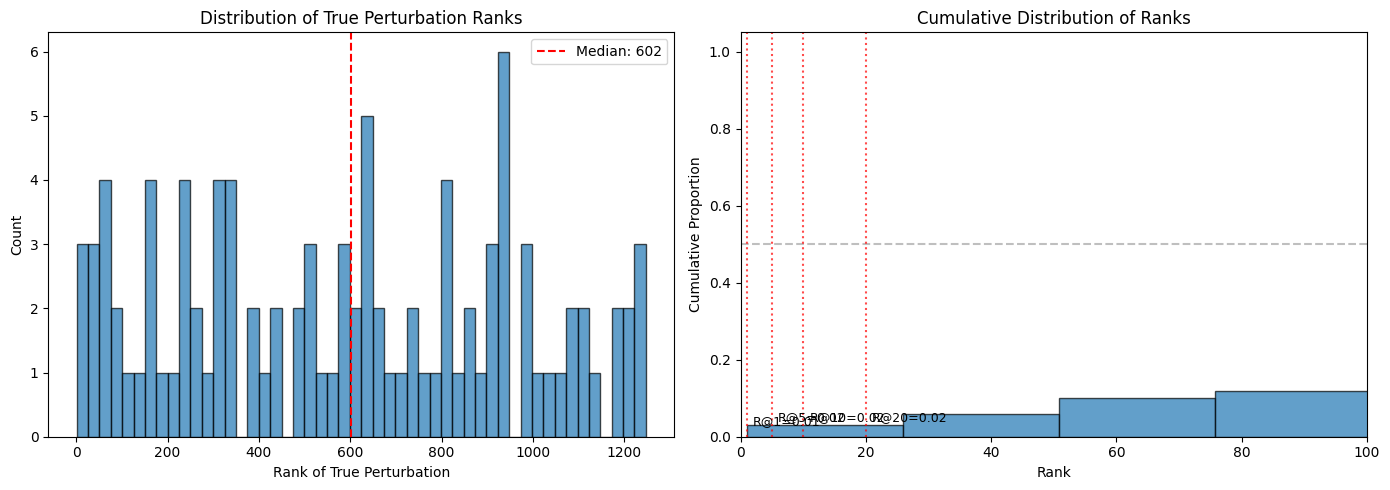

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(ranks, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.median(ranks), color='red', linestyle='--', label=f'Median: {np.median(ranks):.0f}')
axes[0].set_xlabel('Rank of True Perturbation')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of True Perturbation Ranks')
axes[0].legend()

axes[1].hist(ranks, bins=50, edgecolor='black', alpha=0.7, cumulative=True, density=True)
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
for k in [1, 5, 10, 20]:
    recall = np.mean(ranks <= k)
    axes[1].axvline(k, color='red', linestyle=':', alpha=0.7)
    axes[1].text(k + 1, recall + 0.02, f'R@{k}={recall:.2f}', fontsize=9)
axes[1].set_xlabel('Rank')
axes[1].set_ylabel('Cumulative Proportion')
axes[1].set_title('Cumulative Distribution of Ranks')
axes[1].set_xlim(0, min(100, ranks.max()))

plt.tight_layout()
plt.show()

## Comparison to Random Baseline

In [10]:
random_expected_mrr = 1.0 / n_perturbations * sum(1.0/i for i in range(1, n_perturbations + 1))
random_median_rank = n_perturbations / 2

print('COMPARISON TO RANDOM BASELINE')
print('=' * 60)
print(f'Total perturbations in bank: {n_perturbations}')
print()
print(f'{"Metric":>20} | {"Model":>10} | {"Random":>10} | {"Improvement":>12}')
print('-' * 60)
print(f'{"MRR":>20} | {np.mean(reciprocal_ranks):>10.4f} | {random_expected_mrr:>10.4f} | {np.mean(reciprocal_ranks)/random_expected_mrr:>11.1f}x')
print(f'{"Median Rank":>20} | {np.median(ranks):>10.0f} | {random_median_rank:>10.0f} | {random_median_rank/np.median(ranks):>11.1f}x')

for k in K_VALUES:
    model_recall = np.mean(ranks <= k)
    random_recall = k / n_perturbations
    improvement = model_recall / random_recall if random_recall > 0 else float('inf')
    print(f'{f"Recall@{k}":>20} | {model_recall:>10.4f} | {random_recall:>10.4f} | {improvement:>11.1f}x')

COMPARISON TO RANDOM BASELINE
Total perturbations in bank: 1250

              Metric |      Model |     Random |  Improvement
------------------------------------------------------------
                 MRR |     0.0189 |     0.0062 |         3.1x
         Median Rank |        602 |        625 |         1.0x
            Recall@1 |     0.0100 |     0.0008 |        12.5x
            Recall@5 |     0.0200 |     0.0040 |         5.0x
           Recall@10 |     0.0200 |     0.0080 |         2.5x
           Recall@20 |     0.0200 |     0.0160 |         1.2x
           Recall@50 |     0.0600 |     0.0400 |         1.5x


## Error Analysis

In [11]:
worst_idx = np.argsort(ranks)[-5:][::-1]
best_idx = np.argsort(ranks)[:5]

print('BEST RETRIEVALS (lowest rank = best):')
for idx in best_idx:
    pid = eval_pert_ids[idx]
    print(f'  Perturbation {pid}: Rank {ranks[idx]}')

print()
print('WORST RETRIEVALS (highest rank = worst):')
for idx in worst_idx:
    pid = eval_pert_ids[idx]
    print(f'  Perturbation {pid}: Rank {ranks[idx]}')

BEST RETRIEVALS (lowest rank = best):
  Perturbation 549: Rank 1
  Perturbation 141: Rank 2
  Perturbation 859: Rank 23
  Perturbation 891: Rank 35
  Perturbation 531: Rank 44

WORST RETRIEVALS (highest rank = worst):
  Perturbation 1110: Rank 1247
  Perturbation 278: Rank 1245
  Perturbation 758: Rank 1242
  Perturbation 661: Rank 1203
  Perturbation 422: Rank 1200


## Benchmark Results

In [12]:
print('=' * 70)
print('EVAL 3: PERTURBATION RETRIEVAL - BENCHMARK RESULTS')
print('=' * 70)
print()
print('CONFIGURATION')
print(f'  Test perturbations evaluated: {len(eval_pert_ids)}')
print(f'  Total perturbations in bank: {n_perturbations}')
print(f'  Genes: {n_genes}')
print(f'  Similarity metric: Cosine')
print()
print('RETRIEVAL METRICS')
print(f'  Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}')
print(f'  Median Rank: {np.median(ranks):.0f} / {n_perturbations}')
print(f'  Mean Rank: {np.mean(ranks):.1f} / {n_perturbations}')
print()
print('RECALL@K')
for k in K_VALUES:
    recall = np.mean(ranks <= k)
    random = k / n_perturbations
    bar = '█' * int(recall * 20)
    print(f'  @{k:>2}: {recall:.3f} {bar} ({recall/random:.0f}x random)')

EVAL 3: PERTURBATION RETRIEVAL - BENCHMARK RESULTS

CONFIGURATION
  Test perturbations evaluated: 100
  Total perturbations in bank: 1250
  Genes: 5000
  Similarity metric: Cosine

RETRIEVAL METRICS
  Mean Reciprocal Rank (MRR): 0.0189
  Median Rank: 602 / 1250
  Mean Rank: 590.2 / 1250

RECALL@K
  @ 1: 0.010  (12x random)
  @ 5: 0.020  (5x random)
  @10: 0.020  (2x random)
  @20: 0.020  (1x random)
  @50: 0.060 █ (2x random)


In [13]:
update_eval_report('eval_3_perturbation_retrieval', {
    'config': {
        'test_perturbations_evaluated': len(eval_pert_ids),
        'total_perturbations_in_bank': n_perturbations,
        'genes': n_genes,
        'similarity_metric': 'cosine'
    },
    'metrics': {
        'mrr': float(np.mean(reciprocal_ranks)),
        'median_rank': float(np.median(ranks)),
        'mean_rank': float(np.mean(ranks))
    },
    'recall_at_k': {
        str(k): {
            'recall': float(np.mean(ranks <= k)),
            'vs_random': float(np.mean(ranks <= k) / (k / n_perturbations))
        } for k in K_VALUES
    }
})

Updated eval_report.json
